# Project delivery rate exploratory analysis

## *Exploration*
1. Exploratory analysis
2. Outliars
3. Relationship

## *DR(Delivery Rate) Computation*
1. General DR
2. DR by analysis type
3. DR by PRj_Type
4. DR by person

In [18]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>
'''Click this button to hide/show Codes'''

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import HTML

%matplotlib inline

In [3]:
df = pd.read_excel("../input/2017-08-21.xlsx", sheet = 'SQL Results')
df = df.drop(df.loc[df['Standard_Time'].isnull()].index)
#df = df.reset_index(drop = True)
df.head()

,,子项目编码,项目名称,Analysis_Type,Prj_Type,信息负责人,Executor,结题日期,Plan_Time,Down_Time,Qual_Time,End_Time,结题审核,Standard_Time
0,1028,MUSunaR,una170508徐婧小鼠RNA-Seq,标准信息分析,RNA-Seq,管海娇,guanhaijiao,2017-05-23 15:19:50,2017-05-12 14:30:01,NaT,2017-05-22 23:46:29,2017-05-23,2017-05-23,5.0
1,770,MONoggR,ogg170505张伟10红曲霉RNA-Seq,标准信息分析,RNA-Seq,邹利君,zoulijun,2017-05-23 18:06:09,2017-05-19 17:46:11,NaT,2017-05-22 18:07:19,2017-05-23,2017-05-23,5.0
4,196,SCOsbwE,sbw170113郑小敏蝎子Eukaryote Transcriptome Resequen...,标准信息分析,Eukaryote Transcriptome Resequencing,邹利君,zoulijun,2017-05-23 18:10:07,2017-03-14 13:53:31,2017-01-26,2017-05-22 15:18:38,2017-05-23,2017-05-23,10.0
6,600,INSdqjT,dqj170427于杨阳昆虫Eukaryote de novo Transcriptome,标准+高级信息分析,Eukaryote de novo Transcriptome,邹利君,zoulijun,2017-05-23 18:11:39,2017-05-11 15:44:29,NaT,2017-05-22 11:39:59,2017-05-23,2017-05-23,10.0
7,365,WHEvmeE,vme170331谢尚波小麦Eukaryote Transcriptome Resequen...,标准信息分析,Eukaryote Transcriptome Resequencing,管海娇,guanhaijiao,2017-05-24 11:57:13,2017-04-14 14:23:59,NaT,2017-05-24 10:32:30,2017-05-24,2017-05-24,10.0


In [4]:
fo = df[df['Analysis_Type'] == '纯过滤']
df = df.drop(fo.loc[fo['Down_Time'].isnull()].index)
df = df.set_index('End_Time')
df = df['2017-06':'2017-09']
df = df.reset_index()

## So nulls are mainly in Down_Time

In [470]:
# Nulls
df.isnull().mean().round(3)

End_Time         0.000
                 0.000
子项目编码            0.000
项目名称             0.000
Analysis_Type    0.000
Prj_Type         0.000
信息负责人            0.000
Executor         0.000
结题日期             0.000
Plan_Time        0.000
Down_Time        0.495
Qual_Time        0.000
结题审核             0.000
Standard_Time    0.000
dtype: float64

## 使用下机时间和方案更新时间较后的一个，跟结题申请时间比较
## 计算得到项目执行时间

# 以结题审核时间为准计算交付率

In [474]:
# Compute Prject Work Days 以结题审核时间为准
df['Down_Time'] = df['Down_Time'].fillna(0)
df['Start_Time'] = [df['Down_Time'][i] > df['Plan_Time'][i] and df['Down_Time'][i] or df['Plan_Time'][i] for i in df.index]
dd = (df['结题审核'] - df['Start_Time'])
dd = dd.dt.days
df['Work_days'] = dd
df['Work_days'].describe()

count    1110.000000
mean       13.545946
std        17.758909
min       -39.000000
25%         4.000000
50%         8.000000
75%        18.000000
max       238.000000
Name: Work_days, dtype: float64

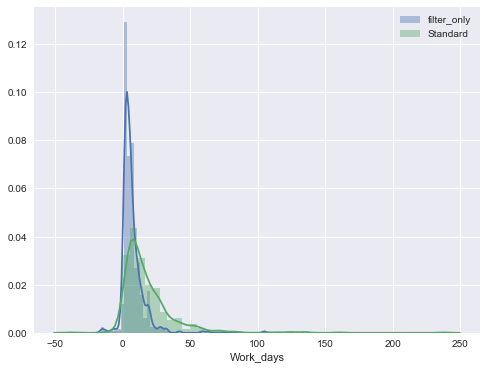

In [475]:
data_filter_only = df[df['Analysis_Type'] == '纯过滤']
data_std_prj = df[df['Analysis_Type'] != '纯过滤']
f, ax = plt.subplots(figsize=(8,6))
p1 = sns.distplot(data_filter_only['Work_days'])
p1 = sns.distplot(data_std_prj['Work_days'])
p1.legend(labels=('filter_only', 'Standard'))

In [476]:
genral_dr = (df['Work_days'] <= df['Standard_Time']).mean()
std_dr = (data_std_prj['Work_days'] <= data_std_prj['Standard_Time']).mean()
fo_dr = (data_filter_only['Work_days'] <= data_filter_only['Standard_Time']).mean()
#print("", round(genral_dr, 3), round(std_dr, 3), round(fo_dr, 3))
print(" 整体合格率: %.2f%% \n 标准项目合格率: %.2f%% \n 只过滤合格率: %.2f%% \n" %(genral_dr*100, std_dr*100, fo_dr*100))

 整体合格率: 37.48% 
 标准项目合格率: 24.96% 
 只过滤合格率: 54.09% 



# 以申请结题时间为准计算交付率

In [5]:
# Compute Prject Work Days 以结题申请时间为准
df['Down_Time'] = df['Down_Time'].fillna(0)
df['Start_Time'] = [df['Down_Time'][i] > df['Plan_Time'][i] and df['Down_Time'][i] or df['Plan_Time'][i] for i in df.index]
dd = (df['End_Time'] - df['Start_Time'])
dd = dd.dt.days
df['Work_days'] = dd
df['Work_days'].describe()

count    1110.000000
mean       13.191892
std        17.587656
min       -39.000000
25%         4.000000
50%         8.000000
75%        17.000000
max       230.000000
Name: Work_days, dtype: float64

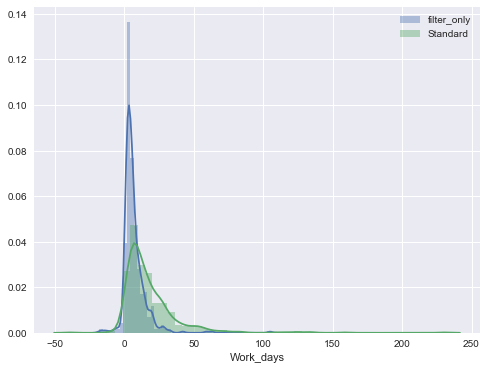

In [472]:
data_filter_only = df[df['Analysis_Type'] == '纯过滤']
data_std_prj = df[df['Analysis_Type'] != '纯过滤']
f, ax = plt.subplots(figsize=(8,6))
p1 = sns.distplot(data_filter_only['Work_days'])
p1 = sns.distplot(data_std_prj['Work_days'])
p1.legend(labels=('filter_only', 'Standard'))

In [473]:
genral_dr = (df['Work_days'] <= df['Standard_Time']).mean()
std_dr = (data_std_prj['Work_days'] <= data_std_prj['Standard_Time']).mean()
fo_dr = (data_filter_only['Work_days'] <= data_filter_only['Standard_Time']).mean()
#print("", round(genral_dr, 3), round(std_dr, 3), round(fo_dr, 3))
print(" 整体合格率: %.2f%% \n 标准项目合格率: %.2f%% \n 只过滤合格率: %.2f%% \n" %(genral_dr*100, std_dr*100, fo_dr*100))

 整体合格率: 39.55% 
 标准项目合格率: 26.54% 
 只过滤合格率: 56.81% 



In [6]:
eff_person = df.groupby('Executor').agg('sum')
eff_person['eff'] = eff_person.Work_days / eff_person.Standard_Time
eff_person.sort_values('eff')

,,Standard_Time,Work_days,eff
Executor,,,,
chenwenjing1,40796,80.0,42,0.525000
guowenwen,73561,150.0,102,0.680000
wuzijing,148136,430.0,534,1.241860
likalin,58252,210.0,265,1.261905
zhuyanchao,13551,25.0,32,1.280000
zhangdichang,22695,45.0,72,1.600000
xuweiling,64103,165.0,276,1.672727
yangli2,136029,295.0,538,1.823729
guanhaijiao,346200,1245.0,2363,1.897992


## Work Days boxplot of Persion

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

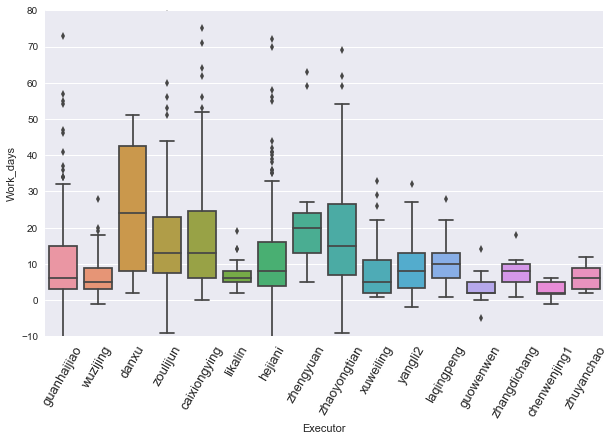

In [478]:
data = pd.concat([df['Work_days'], df['Executor']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='Executor', y="Work_days", data=data)
fig.axis(ymin=-10, ymax=80)
plt.xticks(rotation=60, size=13)

In [479]:
(df['Work_days'] < 0).mean()

0.017117117117117116

### 下机时间的大量缺失是造成项目执行时间出现一些奇怪的值以致于使得统计较为困难的一个原因

**从以上可以看出有很多一些项目执行时间小于0，大概占1.7%  
这种情况可能是后续又更新了方案再次分析，所以也认为是交付合格。**

## 只过滤，标准项目每月交付率

In [7]:
df_period = df.set_index('End_Time')['2017-06':'2017-08']
df_period['DR'] = (df_period['Work_days'] <= df_period['Standard_Time'])
#df_period.head()
period_filter_only = df_period[df_period['Analysis_Type'] == '纯过滤'].resample('M')
period_std_pgj = df_period[df_period['Analysis_Type'] != '纯过滤'].resample('M')
print("只过滤6，7，8月交付率")
period_filter_only.mean().to_period('M')

只过滤6，7，8月交付率


,,Standard_Time,Work_days,DR
End_Time,,,,
2017-06,1214.254054,5.0,6.810811,0.524324
2017-07,2112.604762,5.0,7.404762,0.561905
2017-08,2673.597561,5.0,4.963415,0.682927


In [8]:
print("标准项目6，7，8月交付率")
period_std_pgj.mean().to_period('M')

标准项目6，7，8月交付率


,,Standard_Time,Work_days,DR
End_Time,,,,
2017-06,1158.318584,6.592920,17.172566,0.305310
2017-07,1946.795276,7.047244,18.220472,0.208661
2017-08,2456.679739,7.712418,19.032680,0.300654


## 每人每月交付率

In [12]:
df_person = df_period.groupby('Executor')
df_person.resample('MS').mean()

Standard_Time  Work_days        DR
Executor     End_Time                                                   
caixiongying 2017-06-01  1181.954545       6.590909  15.477273  0.318182
             2017-07-01  1975.431373       7.549020  19.568627  0.176471
             2017-08-01  2391.428571       7.571429  17.485714  0.485714
chenwenjing1 2017-07-01  2392.666667       5.000000   3.000000  1.000000
             2017-08-01  2586.000000       5.000000   2.538462  0.923077
danxu        2017-06-01   961.272727       8.181818  24.909091  0.272727
guanhaijiao  2017-06-01  1228.423913       5.652174  11.054348  0.565217
             2017-07-01  2059.623377       6.428571  12.155844  0.454545
             2017-08-01  2572.206897       7.931034  14.137931  0.413793
guowenwen    2017-07-01  2263.100000       5.000000   2.750000  0.850000
             2017-08-01  2829.900000       5.000000   4.700000  0.700000
hejiani      2017-06-01  1068.291139       5.822785  10.253165  0.455696
             2017-07-01  1875.189189       5.945946  12.864865  0.472973
             2017-08-01  2511.214286       6.904762  14.880952  0.380952
laqingpeng   2017-07-01  2466.333333       5.000000   8.433333  0.300000
             2017-08-01  2632.043478       5.000000  11.521739  0.173913
likalin      2017-06-01  1273.000000       5.000000   5.303030  0.424242
             2017-07-01  1804.777778       5.000000  10.000000  0.000000
wuzijing     2017-06-01  1305.904762       5.119048   6.928571  0.476190
             2017-07-01  2072.189189       5.000000   5.702703  0.621622
             2017-08-01  2769.500000       5.000000   5.333333  0.500000
xuweiling    2017-06-01   954.666667       5.000000   9.333333  0.166667
             2017-07-01  2058.166667       5.000000   8.875000  0.625000
             2017-08-01  2993.000000       5.000000   2.333333  1.000000
yangli2      2017-07-01  2226.279070       5.116279  11.162791  0.232558
             2017-08-01  2686.600000       5.000000   3.866667  0.800000
zhangdichang 2017-07-01  2579.500000       5.000000   9.000000  0.000000
             2017-08-01  2505.142857       5.000000   7.714286  0.428571
zhaoyongtian 2017-06-01  1222.886364       6.363636  16.795455  0.204545
             2017-07-01  1691.347826       6.956522  21.000000  0.086957
             2017-08-01  2165.857143       7.619048  24.666667  0.285714
zhengyuan    2017-06-01  1063.812500       5.000000  16.687500  0.125000
             2017-07-01   572.333333       5.000000  75.666667  0.000000
zhuyanchao   2017-08-01  2710.200000       5.000000   6.400000  0.400000
zoulijun     2017-06-01  1204.863636       6.477273  18.886364  0.340909
             2017-07-01  2019.622222       7.555556  17.222222  0.244444
             2017-08-01  2554.730769       9.038462  24.076923  0.192308

# 每种项目类型的交付率

In [40]:
df_prj_type = df_period[df_period['Analysis_Type'] != '纯过滤']
df_prj_type = df_prj_type[(df_prj_type.Prj_Type == 'RNA-Seq') | (df_prj_type.Prj_Type == 'Eukaryote Transcriptome Resequencing') | (df_prj_type.Prj_Type == 'Eukaryote de novo Transcriptome')]
df_prj_type = df_prj_type.groupby('Prj_Type')
df_prj_type.resample('MS').mean()

Standard_Time  \
Prj_Type                             End_Time                                 
Eukaryote Transcriptome Resequencing 2017-06-01   994.854167           10.0   
                                     2017-07-01  1735.314286           10.0   
                                     2017-08-01  2373.078431           10.0   
Eukaryote de novo Transcriptome      2017-06-01   846.956522           10.0   
                                     2017-07-01  1563.794118           10.0   
                                     2017-08-01  2277.156250           10.0   
RNA-Seq                              2017-06-01  1256.136364            5.0   
                                     2017-07-01  2126.536913            5.0   
                                     2017-08-01  2599.657143            5.0   

                                                 Work_days        DR  
Prj_Type                             End_Time                         
Eukaryote Transcriptome Resequencing 2017-06-01  21.333333  0.291667  
                                     2017-07-01  24.085714  0.242857  
                                     2017-08-01  22.000000  0.254902  
Eukaryote de novo Transcriptome      2017-06-01  24.826087  0.347826  
                                     2017-07-01  24.735294  0.088235  
                                     2017-08-01  28.218750  0.218750  
RNA-Seq                              2017-06-01  14.597403  0.305195  
                                     2017-07-01  14.046980  0.221477  
                                     2017-08-01  12.671429  0.371429

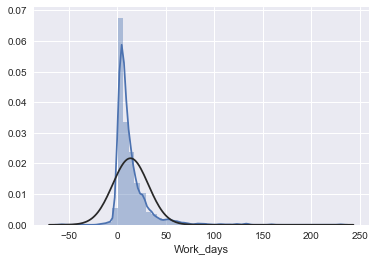

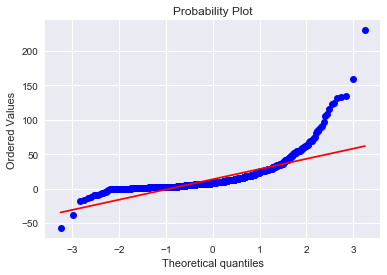

In [335]:
# Histogram and normal probability plot
sns.distplot(df['Work_days'], fit=norm)
fig = plt.figure()
res = stats.probplot(df['Work_days'], plot=plt)

### Work Days absolutely not normal
### Do some normalization

In [336]:
#skewness and kurtosis
print("Skewness: %f" % dd.skew())
print("Kurtosis: %f" % dd.kurt())

Skewness: 4.005977
Kurtosis: 28.008099


In [337]:
# Normalization
dd = dd[dd>0]
dd = np.log(dd)

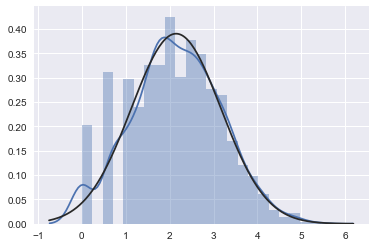

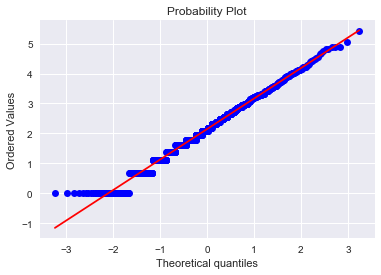

In [338]:
sns.distplot(dd, fit=norm)
fig = plt.figure()
res = stats.probplot(dd, plot=plt)

### Much Normaler